In [519]:
from __future__ import division

import numpy as np
from numpy import pi, sqrt,cos,sin,sinc

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25, 'legend.handlelength'  : 1.25})
%matplotlib inline

In [655]:
data_path = 'outputs/beta-eady_C_kappa8_256.npz'
beta_eady = np.load(data_path)

In [656]:
kappa = beta_eady['kappa']
qn = beta_eady['efunc'][1:-1]    # modal q
vtht = beta_eady['efunc'][0]     # theta +
vthb = beta_eady['efunc'][-1]    # theta -
N = beta_eady['Nmodes']
cr = beta_eady['c'].real

In [657]:
# vertical coordinate
z = np.linspace(-1.,0.,N+3)
dz = z[2]-z[1]

# horizontal coordinate
x = np.linspace(0,np.pi,150)

# grid
X,Z = np.meshgrid(x,z)

In [658]:
def alpha_n(n,kappa):
    """ Compute the inverse Helmholtz operator in
             Fourier space """
    return -1./( kappa**2 + (n*pi)**2 )

In [659]:
for i in range(N+1):
    if i == 0 : 
        q = qn[0]*np.ones(z.size)
        psi = (qn[0] - vtht + vthb)*np.ones(z.size)*alpha_n(0,kappa)
    else: 
        q+= sqrt(2)*qn[i]*cos(i*pi*z)
        psi+= sqrt(2)*(qn[i] - sqrt(2)*vtht + sqrt(2)*((-1)**i * vthb) )\
        *cos(i*pi*z)*alpha_n(i,kappa)

In [660]:
qabs = np.abs(q)
qphase = np.arctan2(q.imag,q.real)
psiabs = np.abs(psi)
psiphase = np.arctan2(psi.imag,psi.real)

vthtabs = np.abs(vtht)
vthbabs = np.abs(vthb)
vthtphase = np.arctan2(vtht.imag,vtht.real)
vthbphase = np.arctan2(vthb.imag,vthb.real)

In [661]:
Qabs = qabs.repeat(x.size).reshape(z.size,x.size)
Qphase = qphase.repeat(x.size).reshape(z.size,x.size)
Psiabs = psiabs.repeat(x.size).reshape(z.size,x.size)
Psiphase = psiphase.repeat(x.size).reshape(z.size,x.size)

In [662]:
PV = Qabs*np.cos(kappa*X + Qphase)
PSI = Psiabs*np.cos(kappa*X + Psiphase)

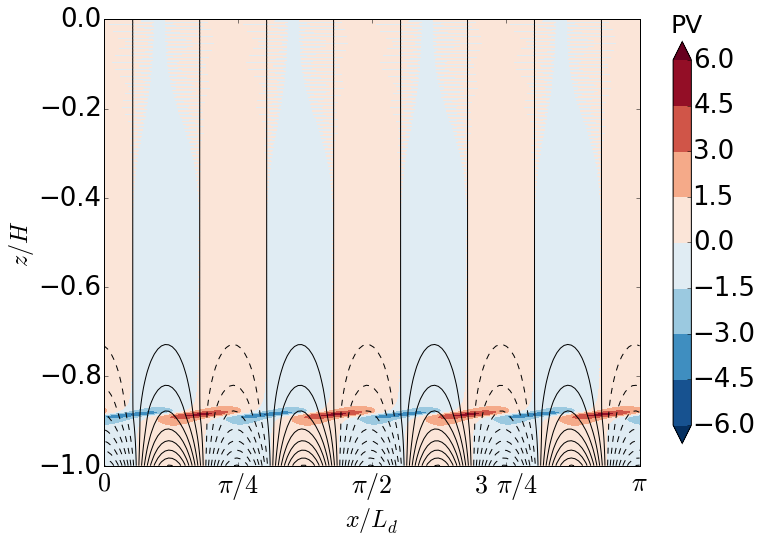

In [665]:
plt.figure(figsize=(12,8))
plt.contour(X,Z,PSI,20,colors='k')      
plt.contourf(X,Z,PV,np.linspace(-6.,6.,9),cmap='RdBu_r',extend='both') 
#plt.text(-0.325,zc,r' $z_c \rightarrow$',fontsize=25)
cb = plt.colorbar(extend='both',shrink=.9)
cb.ax.text(.0,1.075,'PV',rotation=0,fontsize=25)
#plt.text(1.7, -.1, r"Eady Problem, $\kappa = 2$, Approximation C", size=25, rotation=0.,\
#            ha="center", va="center",\
#            bbox = dict(boxstyle="round",ec='k',fc='w'))
#plt.ylim(-.25,0)
plt.xticks([0.,pi/4,pi/2,3*pi/4,pi],[r'$0$',r'$\pi/4$',r'$\pi/2$',\
        r'$3\,\pi/4$',r'$\pi$'])
plt.ylabel('$z/H$')
plt.xlabel(r'$x/L_d$')
plt.savefig('figs/wave-structure_pv_psi_kappa_2_C_N64.eps',bbox_inches = 'tight')

### Computing the buoyancy

1st method finite differences

In [666]:
def D_matrices(N):
    ''' create an N x N difference matrices 
    
    D1 :: first-order, centered difference
    D2 :: second-order, centered difference 
                
                                            '''
    D2 = np.zeros((N,N))
    D1 = np.zeros((N,N))
    for i in range(N):
        D2[i,i] = -2.
        if i<N-1: 
            D2[i,i+1],D1[i,i+1] = 1.,-1
        if i>0: 
            D2[i,i-1],D1[i,i-1] = 1.,1.
    return D1,D2

In [667]:
# vertical coordinate
z_fd = np.linspace(-1.,0.,N+3)

# horizontal coordinate
x= np.linspace(0,np.pi,150)

# grid
X,Z_fd= np.meshgrid(x,z_fd)

D1,_ = D_matrices(z_fd.size)
D1 = -D1/(2*dz)                # correct order for this grid

In [668]:
Bfd = np.empty(PSI.shape)
for i in range(x.size):
    Bfd[:,i] = np.dot(D1,PSI[:,i])  

Append boundary values

In [669]:
Bfd[0,:] = vthbabs*cos(kappa*x + vthbphase)
Bfd[-1,:] = vthtabs*cos(kappa*x + vthtphase)

In [670]:
ct = np.linspace(-.7,.7,20)

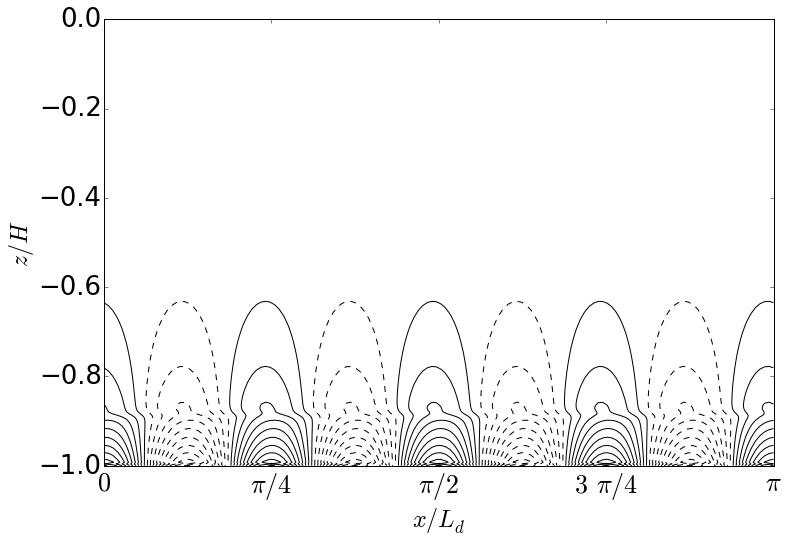

In [671]:
plt.figure(figsize=(12,8))
plt.contour(X,Z_fd,Bfd,ct,colors='k')      
plt.xticks([0.,pi/4,pi/2,3*pi/4,pi],[r'$0$',r'$\pi/4$',r'$\pi/2$',\
        r'$3\,\pi/4$',r'$\pi$'])
plt.ylabel('$z/H$')
plt.xlabel(r'$x/L_d$')
plt.savefig('figs/wave-structure_b_psi_kappa_2_C_N128_fd.eps',bbox_inches = 'tight')

Method 2: use the Galerkin series

In [619]:
z2 = z_fd[1:-1]

for i in range(N+1):
    if i == 0 : 
        b = np.zeros(z2.size) + 0.j
    else: 
        b+= -i*pi*sqrt(2)*(qn[i] - sqrt(2)*vtht + sqrt(2)*((-1)**i * vthb))\
        *sin(i*pi*z2)*alpha_n(i,kappa)

In [620]:
b = np.append(vthb,b)
b = np.append(b,vtht)
z2 = np.append(-1,z2)
z2 = np.append(z2,0)
babs = np.abs(b)
bphase = np.arctan2(b.imag,b.real)

# grid
X2,Z2 = np.meshgrid(x,z2)

In [621]:
babs = babs.repeat(x.size).reshape(z.size,x.size)
bphase = bphase.repeat(x.size).reshape(z.size,x.size)

In [622]:
B2 = babs*np.cos(kappa*X + bphase)

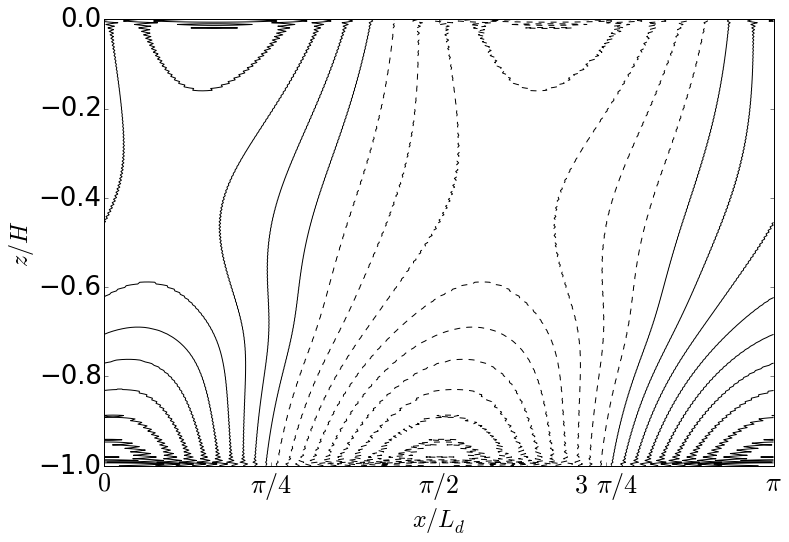

In [623]:
plt.figure(figsize=(12,8))
plt.contour(X2,Z2,B2,ct,colors='k')  
#plt.contour(X,Z_fd,Bfd,ct,colors='m')
#plt.ylim(-.25,0)
plt.xticks([0.,pi/4,pi/2,3*pi/4,pi],[r'$0$',r'$\pi/4$',r'$\pi/2$',\
        r'$3\,\pi/4$',r'$\pi$'])
plt.ylabel('$z/H$')
plt.xlabel(r'$x/L_d$')
plt.savefig('figs/wave-structure_b_psi_kappa_2_C_N128.eps',bbox_inches = 'tight')

### Trying to remove gibbs oscillations: Laczos $\sigma$ factor 

In [649]:
z3 = z_fd[1:-1]

for i in range(N+1):
    if i == 0 : 
        b3 = np.zeros(z3.size) + 0.j
    else: 
        b3+= -i*pi*sqrt(2)*sinc(i/((N+1)))*(qn[i] - sqrt(2)*vtht + sqrt(2)*((-1)**i * vthb))\
        *sin(i*pi*z3)*alpha_n(i,kappa)

In [650]:
b3 = np.append(vthb,b3)
b3 = np.append(b3,vtht)
z3 = np.append(-1,z3)
z3 = np.append(z3,0)
babs = np.abs(b3)
bphase = np.arctan2(b3.imag,b3.real)

# grid
X3,Z3 = np.meshgrid(x,z3)

In [651]:
babs = babs.repeat(x.size).reshape(z3.size,x.size)
bphase= bphase.repeat(x.size).reshape(z3.size,x.size)

In [652]:
B3 = babs*np.cos(kappa*X3 + bphase)

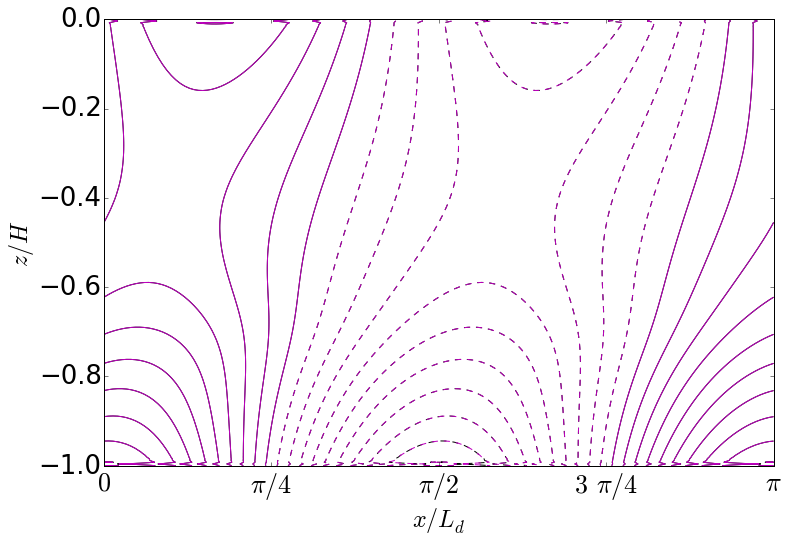

In [654]:
plt.figure(figsize=(12,8))
plt.contour(X3,Z3,B3,ct,colors='k')  
plt.contour(X,Z_fd,Bfd,ct,colors='m')
#plt.ylim(-.25,0)
plt.xticks([0.,pi/4,pi/2,3*pi/4,pi],[r'$0$',r'$\pi/4$',r'$\pi/2$',\
        r'$3\,\pi/4$',r'$\pi$'])
plt.ylabel('$z/H$')
plt.xlabel(r'$x/L_d$')
plt.savefig('figs/wave-structure_b_psi_kappa_2_C_N128.eps',bbox_inches = 'tight')

In [416]:
D1,D2 = D_matrices(z.size)
D1 = np.matrix(D1)/(2*dz)
D1[0,0],D1[0,1] = 1./dz,-1/dz
D1[-1,-1],D1[-1,-2] = -1./dz,1/dz

In [417]:
psiabs = np.abs(psi)
psiphase = np.arctan2(psi.imag,psi.real)
psiabs_prime_fd = np.array( D1*np.matrix(psiabs).T )
psiphase_prime_fd = np.array( D1*np.matrix(psiphase).T )

In [418]:
vthtabs = np.abs(vtht)
vthbabs = np.abs(vthb)
vthtphase = np.arctan2(vtht.imag,vtht.real)
vthbphase = np.arctan2(vthb.imag,vthb.real)

In [419]:
vthtabs = vthtabs.repeat(x.size).reshape(1,x.size)
vthbabs = vthbabs.repeat(x.size).reshape(1,x.size)

vthtphase = vthtphase.repeat(x.size).reshape(1,x.size)
vthbphase = vthbphase.repeat(x.size).reshape(1,x.size)


In [420]:
psiabs = psiabs.repeat(x.size).reshape(z.size,x.size)
psiabs_prime_fd = psiabs_prime_fd.repeat(x.size).reshape(z.size,x.size)
psiphase_prime_fd = psiphase_prime_fd.repeat(x.size).reshape(z.size,x.size)

In [421]:
Bfd = psiabs_prime_fd*cos(kappa*X + psiphase) - psiabs*psiphase_prime_fd*sin(kappa*X + psiphase)

In [422]:
Bfd = np.concatenate((vthbabs*cos(kappa*x+vthbphase),Bfd),axis=0)

In [424]:
# vertical coordinate
dz = .01   # vertical resolution
z = np.linspace(-1.+dz,-dz,100)

# horizontal coordinate
x = np.linspace(0,np.pi,100)

z = np.append(-1.,z)

# grid
X,Z = np.meshgrid(x,z)

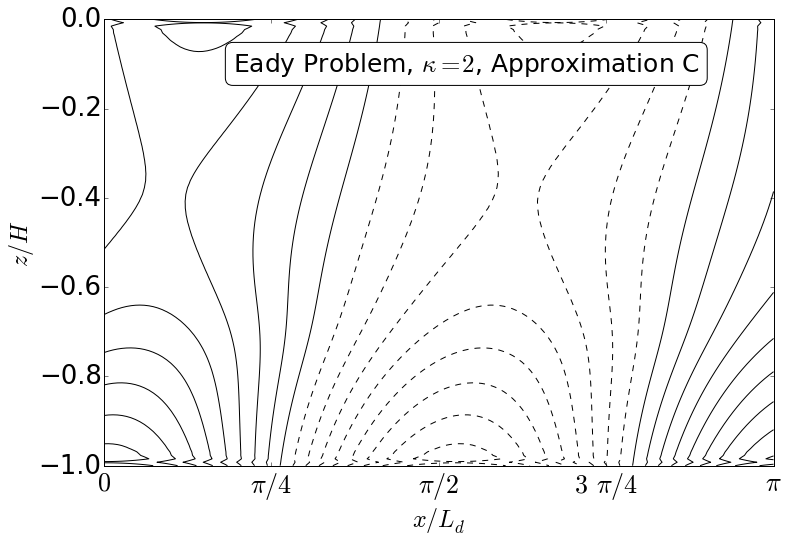

In [368]:
plt.figure(figsize=(12,8))
plt.contour(X,Z,Bfd,20,colors='k')      
#plt.contourf(X,Z,PV,np.linspace(-2.,2.,9),cmap='RdBu_r',extend='both') 
#cb = plt.colorbar(extend='both',shrink=.9)
#cb.ax.text(.0,1.075,'PV',rotation=0,fontsize=25)
plt.text(1.7, -.1, r"Eady Problem, $\kappa = 2$, Approximation C", size=25, rotation=0.,\
            ha="center", va="center",\
            bbox = dict(boxstyle="round",ec='k',fc='w'))
#plt.ylim(-.25,0)
plt.xticks([0.,pi/4,pi/2,3*pi/4,pi],[r'$0$',r'$\pi/4$',r'$\pi/2$',\
        r'$3\,\pi/4$',r'$\pi$'])
plt.ylabel('$z/H$')
plt.xlabel(r'$x/L_d$')
plt.savefig('figs/wave-structure_b_psi_kappa_2_C_N128_fd.eps',bbox_inches = 'tight')